# Models: Collaborative Denoising Auto Encoder

* [Variational AutoEncoders (VAE) with PyTorch](https://avandekleut.github.io/vae/)
* [Deep AutoEncoders for Collaborative Filtering](https://github.com/marlesson/recsys_autoencoders#2-cdae---collaborative-denoising-auto-encoders-for-top-n-recommender-systems)
* [K-means, DBSCAN, GMM, Agglomerative clustering — Mastering the popular models in a segmentation problemK-means, DBSCAN, GMM, Agglomerative clustering — Mastering the popular models in a segmentation problem](https://towardsdatascience.com/k-means-dbscan-gmm-agglomerative-clustering-mastering-the-popular-models-in-a-segmentation-c891a3818e29https://towardsdatascience.com/k-means-dbscan-gmm-agglomerative-clustering-mastering-the-popular-models-in-a-segmentation-c891a3818e29)

In [1]:
%load_ext autoreload
%autoreload 2
BASE_PATH      = '../..'
DATASETS_PATH  = f'{BASE_PATH}/datasets'
EMBEDDING_PATH = f'{DATASETS_PATH}/caa_user_ratings_embedings.json'

In [2]:
import sys
sys.path.append(f'{BASE_PATH}/lib')

In [3]:
import pytorch_common
pytorch_common.__version__

'0.0.23'

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from bunch import Bunch

import torch
from torch.utils.data import DataLoader
from torch.optim      import Adam

import pytorch_common.util as pu
from pytorch_common.callbacks.output import (
    Logger,
    MetricsPlotter
)
from pytorch_common.util import (
    set_device_name,
    get_device,
    LoggerBuilder
)

import model as ml

import data.dataset as ds
import data.plot as pl
import data as dt

import logging
import random

import util as ut

## Setup

In [5]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [6]:
pu.set_device_name('gpu')

pu.get_device(), torch.cuda.is_available(), torch.__version__

(device(type='cuda', index=0), True, '1.11.0')

In [7]:
ut.set_seed(42)

## Helper Functions

In [9]:
def build_user_ratings_df(latent_space, dataset):
    user_ratings_emb_df = pd.DataFrame({
        'user_ratings_emb': [latent_space[idx] for idx in range(latent_space.shape[0])],
        'cluster': medoids_result.labels
    })
    user_ratings_emb_df['user_seq'] = user_ratings_emb_df.index
    
    id_by_seq_dict = ut.id_by_seq(dataset, 'user')
    user_ratings_emb_df['user_id']  = user_ratings_emb_df['user_seq'].apply(lambda seq: id_by_seq_dict[seq])
    return user_ratings_emb_df

In [10]:
def save_df(df, path): return df.to_json  (path, orient='records')
def load_df(path):     return pd.read_json(path, orient='records')

In [11]:
def value_counts(values: np.array):
    df = pd.DataFrame(pd.Series(values).value_counts()).reset_index()
    df = df.rename(columns={'index': 'value', 0: 'count'}) 
    return df[['value', 'count']]

In [12]:
def to_col_dict(df, key, value):
    data = df.drop_duplicates(subset=key)
    data = data[[key, value]]
    return ut.to_dict(data, key, value)

In [13]:
def min_max_scaling_column(df, column):
    # copy the data
    temp = df.copy()

    # apply normalization techniques by Column 1
    temp[column] = (temp[column] - temp[column].min()) / (temp[column].max() - temp[column].min())

    return temp

def min_max_scaling(df, columns):
    for column in columns:
        df = min_max_scaling_column(df, column)
    return df

In [147]:
def movies_instances_by_cluster(user_ratings_emb_df, train_ds):
    groups = user_ratings_emb_df.groupby(['cluster'])

    movies_clusters = {}
    for cluster in user_ratings_emb_df['cluster'].unique():
        df = groups.get_group(cluster)

        user_seqs = df['user_seq'].unique()

        ms = train_ds.data[train_ds.data['user_seq'].isin(user_seqs)]['movie_rating_emb'].values
        movie_seqs = np.concatenate([np.where(m >=3) for m in ms], axis=1).squeeze()

        if cluster not in movies_clusters:
            movies_clusters[cluster] = []

        movies_clusters[cluster].extend(movie_seqs.tolist())
        
    return movies_clusters


def movie_col_instances_by_cluster(movies_clusters, user_ratings_emb_df, dataset, column='movie_genres'):
    col_values_by_movie_seq = to_col_dict(dataset, key='movie_seq', value=column)

    col_values_by_cluster = {}

    for cluster in user_ratings_emb_df['cluster'].unique():
        movie_seq_count = value_counts(movies_clusters[cluster])

        for _, row in movie_seq_count.iterrows():
            value = col_values_by_movie_seq[row['value']]

            if cluster not in col_values_by_cluster:
                col_values_by_cluster[cluster] = []

            if type(value) != list: 
                value = [value]

            col_values_by_cluster[cluster].extend(value * row['count'])
                
    return col_values_by_cluster

def cluster_to_df(clusters, value_column='genre'):
    parts = []
    for cluster, df in clusters.items():
        df = value_counts(df)
        df['cluster'] = cluster 
        parts.append(df)

    cluster_df = pd.concat(parts)
    cluster_df = cluster_df.rename(columns={'value': value_column})
    return cluster_df

def normalize_categories(df, cat_column='genre', excluded_clusters=[]):
    povoted    = df.pivot(index='cluster', columns=cat_column, values='count')
    normalized = min_max_scaling(povoted, povoted.columns.values)

    normalized = pd.DataFrame(normalized.stack()) \
        .reset_index() \
        .rename(columns={0:'percent'})

    normalized = normalized[~normalized.cluster.isin(excluded_clusters)]

    normalized = normalized.sort_values(['cluster', 'percent'], ascending=False)
    
    return normalized

def plot_clusters_cat_var(df, cat_col='genre', figsize=(30,10)):
    sns.set(rc={'figure.figsize':figsize})
    sns.barplot(
        x    = cat_col,
        y    = 'percent',
        hue  = 'cluster',
        data = df
    )
    plt.show()

def plot_cat_column_by_cluster(
    movies_clusters, 
    user_ratings_emb_df, 
    dataset, 
    dataset_column    = 'movie_for_adults',
    target_column     = 'adults',
    figsize           = (4,4),
    excluded_clusters = [1]
):
    adult_by_cluster      = movie_col_instances_by_cluster(
        movies_clusters, 
        user_ratings_emb_df, 
        dataset, 
        column = dataset_column
    )
    cluster_adult_df      = cluster_to_df(
        adult_by_cluster, 
        value_column = target_column
    )
    norm_cluster_adult_df = normalize_categories(
        cluster_adult_df, 
        cat_column        = target_column, 
        excluded_clusters = excluded_clusters
    )
    plot_clusters_cat_var(
        norm_cluster_adult_df, 
        cat_col = target_column, 
        figsize = figsize
    )

## Carga de dataset

In [15]:
dataset  = ds.MovieLensTMDBDatasetFactory.df_from_path(f'{BASE_PATH}/datasets')
train_ds = ds.CollaborativeDenoiseAutoEncoderDataset(dataset)

In [16]:
movies_count = dataset.movie_seq.max() + 1
users_count  = dataset.user_seq.max() + 1

users_count, movies_count

(1885, 17611)

## Entrenamiento

In [19]:
params = Bunch({
    'lr'               : 0.0001,
    'epochs'           : 300,
    'latent_space_dim' : 100,
    'n_workers'        : 24,
    'batch_size'       : 64,
    'train'            : True
})

In [20]:
train_dl = DataLoader(
    train_ds, 
    batch_size  = params.batch_size,
    num_workers = params.n_workers,
    pin_memory  = True,
    shuffle     = True
)

In [17]:
model = ml.CollaborativeDenoisingAutoEncoder(
    n_users            = users_count,
    n_item_ratings     = movies_count,
    latent_space_dim   = params.latent_space_dim,
    encoder_dropout    = 0.2
).to(pu.get_device())

model

CollaborativeDenoisingAutoEncoder(
  (encoder): CollaborativeDenoisingEncoder(
    (users_embedding): Embedding(1885, 100)
    (items_ratings_linear): Linear(in_features=17611, out_features=100, bias=True)
    (noise_layer): Dropout(p=0.2, inplace=False)
    (items_ratings_activation): ReLU()
  )
  (decoder): CollaborativeDecoder(
    (linear): Linear(in_features=100, out_features=17611, bias=True)
  )
)

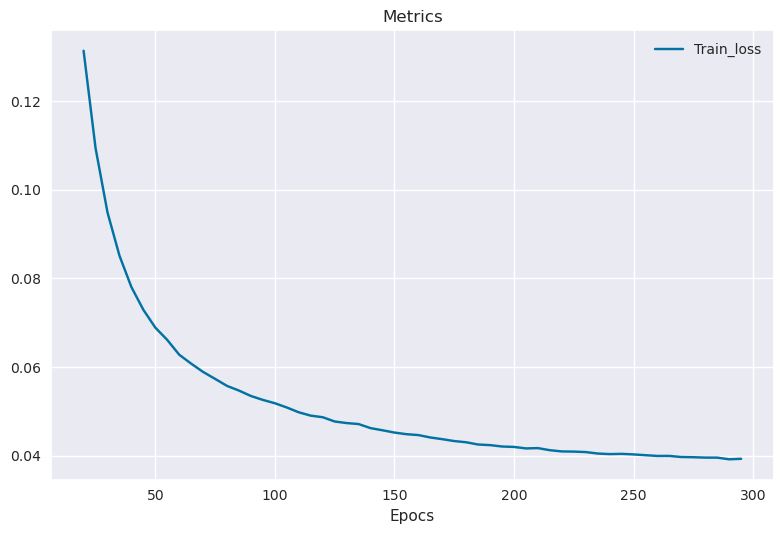

In [18]:
if params.train:
    result = model.fit(
        train_dl,
        epochs      = params.epochs,
        loss_fn     = ml.MSELossFn(),
        optimizer   = Adam(
            params = model.parameters(),
            lr     = params.lr
        ),
        callbacks   = [
            Logger(['time', 'epoch', 'train_loss']),
            MetricsPlotter(
                metrics            = ['train_loss'],
                warmup_count       = 3,
                plot_each_n_epochs = 5,
                reg_each_n_epochs  = 5
            ),
        ]
    )
    result.train_loss

In [19]:
model.save('cae-checkpoint') if params.train else model.load('cae-checkpoint')

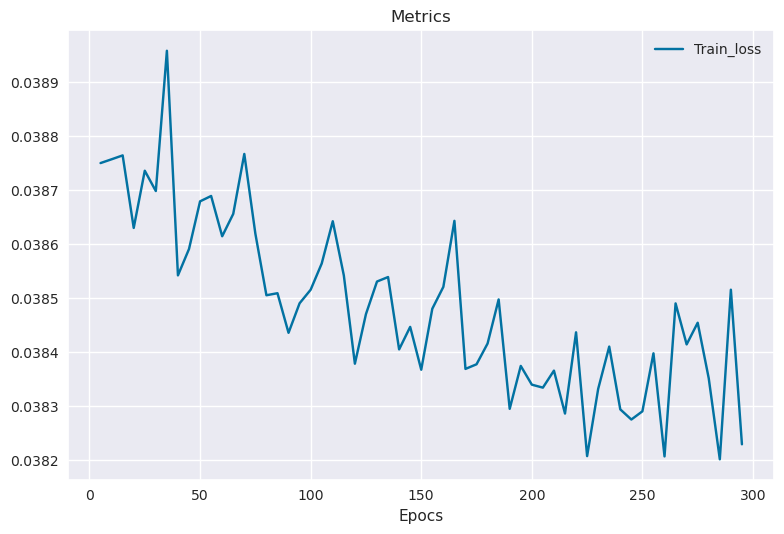

In [20]:
params = Bunch({
    'lr'               : 0.00001,
    'epochs'           : 300,
    'latent_space_dim' : 100,
    'n_workers'        : 24,
    'batch_size'       : 64,
    'train'            : True
})

if params.train:
    result = model.fit(
        train_dl,
        epochs      = params.epochs,
        loss_fn     = ml.MSELossFn(),
        optimizer   = Adam(
            params = model.parameters(),
            lr     = params.lr
        ),
        callbacks   = [
            Logger(['time', 'epoch', 'train_loss']),
            MetricsPlotter(
                metrics            = ['train_loss'],
                plot_each_n_epochs = 5,
                reg_each_n_epochs  = 5
            ),
        ]
    )
    result.train_loss

In [21]:
model.save('cae-checkpoint') if params.train else model.load('cae-checkpoint')

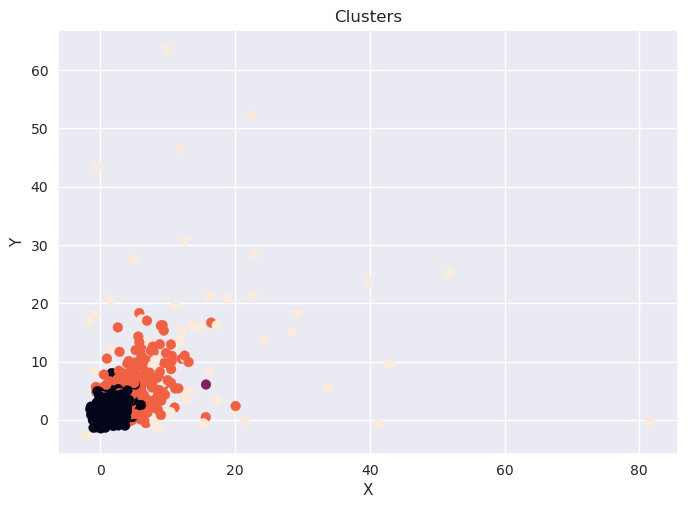

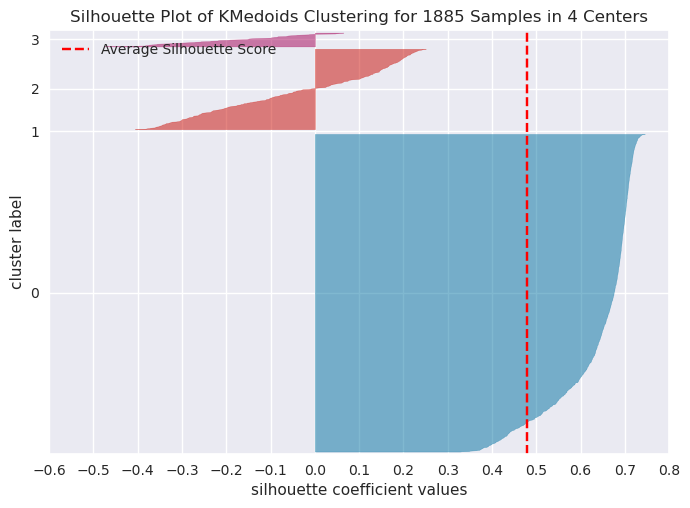

Silhouette: -0.06481176614761353


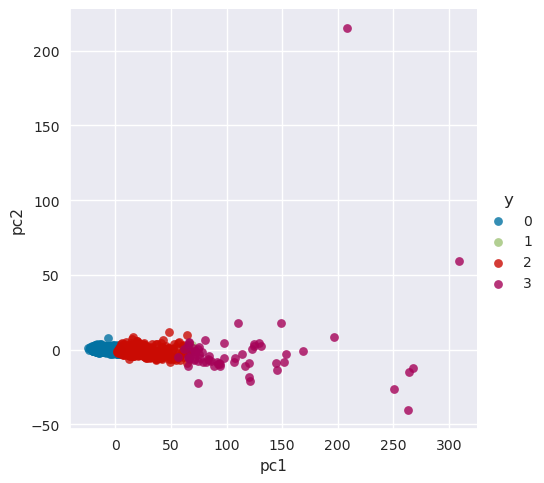

2023-03-26 10:04:04,816 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


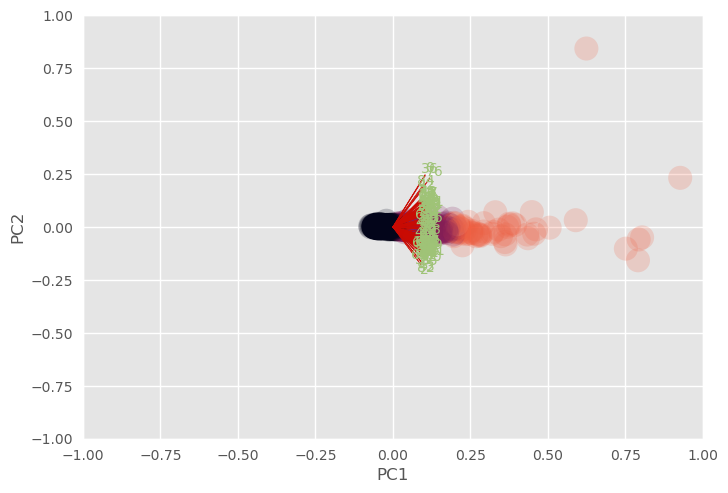

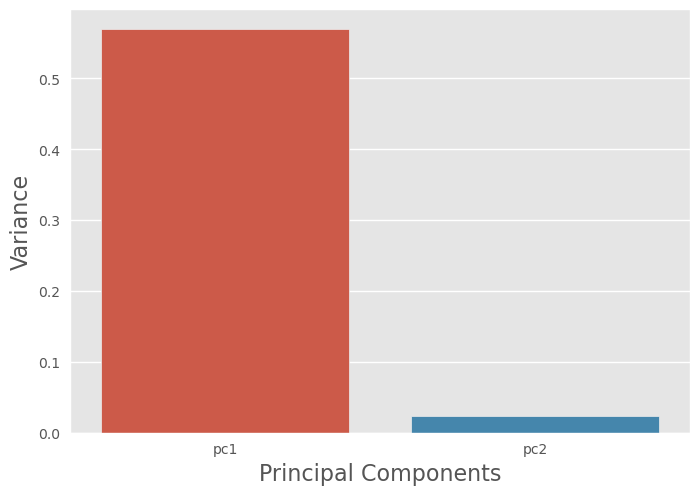

array([0.5691328 , 0.02332585], dtype=float32)

In [22]:
latent_space = model.as_encoder()(train_ds)

medoids_result = ml.KMedoisClustering(n_clusters = 4) \
    .predict(latent_space) \
    .plot()

dt.PCAAnalisys \
    .make_on(
        X = pd.DataFrame(latent_space),
        y = medoids_result.labels,
        n_components = 2
    ) \
    .plot()

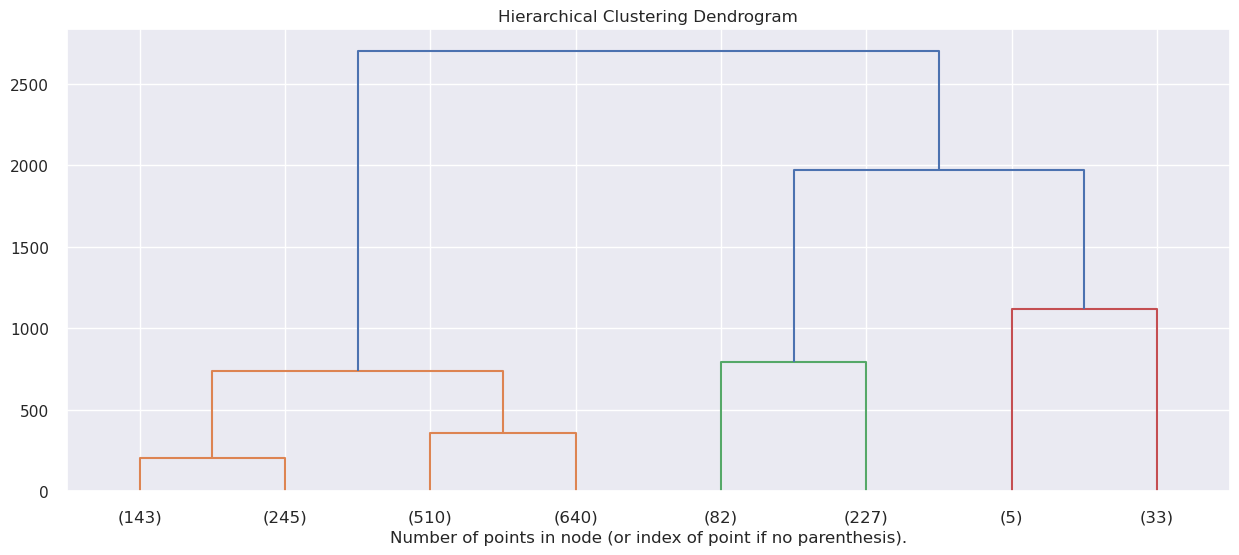

In [22]:
pl.plot_dendrogram(latent_space, max_top_levels=2)

In [23]:
user_ratings_emb_df = build_user_ratings_df(latent_space, dataset)

save_df(user_ratings_emb_df, EMBEDDING_PATH)

In [17]:
user_ratings_emb_df = load_df(EMBEDDING_PATH)

user_ratings_emb_df.head()

,user_ratings_emb,cluster,user_seq,user_id
0,"[2.4185833931, 2.66603899, 2.0027766228, 1.013...",0,0,791
1,"[2.5302855967999998, 2.4597082138, 4.952973365...",2,1,3164
2,"[16.2478485107, 8.2039651871, 19.8265724182, 9...",3,2,3448
3,"[2.9392874240999998, 1.1028394699, 3.460491180...",0,3,4676
4,"[0.1160900965, 2.7482941151, 1.0669522285, 1.5...",0,4,4693


In [138]:
dataset['release_decade'] = dataset['movie_release_year'].apply(lambda year: (year//10)*10 )

In [95]:
movies_clusters = movies_instances_by_cluster(user_ratings_emb_df, train_ds)

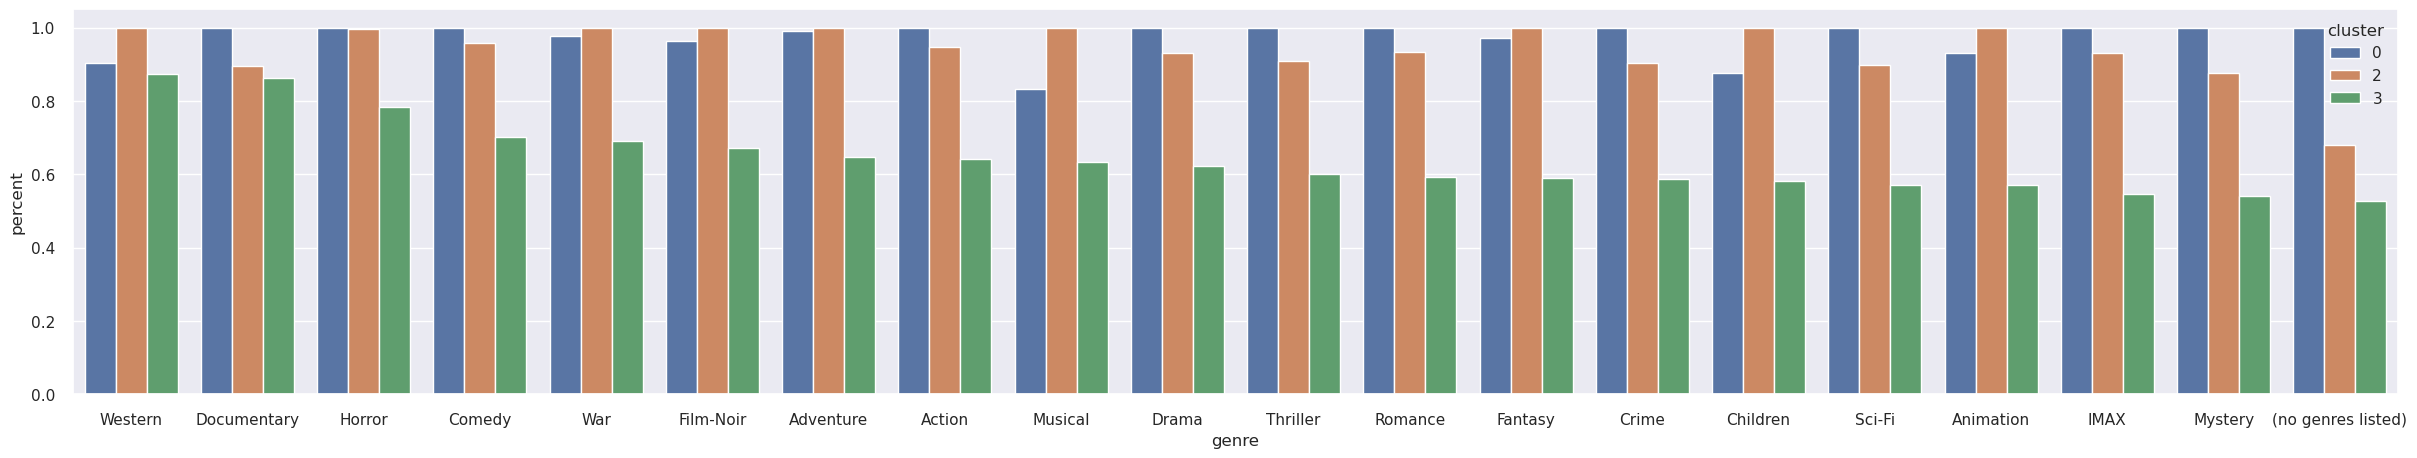

In [125]:
plot_cat_column_by_cluster(
    movies_clusters, 
    user_ratings_emb_df, 
    dataset, 
    dataset_column    = 'movie_genres',
    target_column     = 'genre',
    figsize           = (30,5),
    excluded_clusters = [1]
)

### Observaciones

* El cluster 0 y 2 tiene practicamente los mismos niveles de: Horror, War, Film-Noir, Adventure, Fantasy, Comedy.

* El cluster 0 tiene los mayores niveles de: Domentary, Action, Drama, Thiler, Romance, Crime, Sci-Fi. IMAX, Mystery. 

* El cluster 2 tiene los mayores niveles de: Western, Musical, Children, Animation.

* El cluster 3 Tiene menos niveles en todas las categorias, podriamos dividirlo en dos grupos izquierdo y derecho. A Izquierda crece, a derecha decrece.

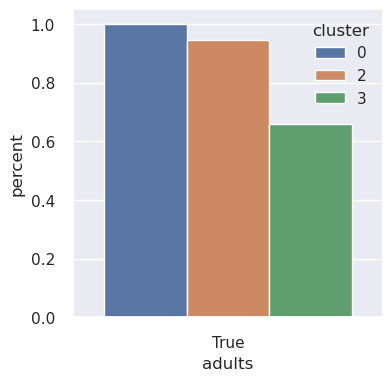

In [126]:
plot_cat_column_by_cluster(
    movies_clusters, 
    user_ratings_emb_df, 
    dataset, 
    dataset_column    = 'movie_for_adults',
    target_column     = 'adults',
    figsize           = (4,4),
    excluded_clusters = [1]
)

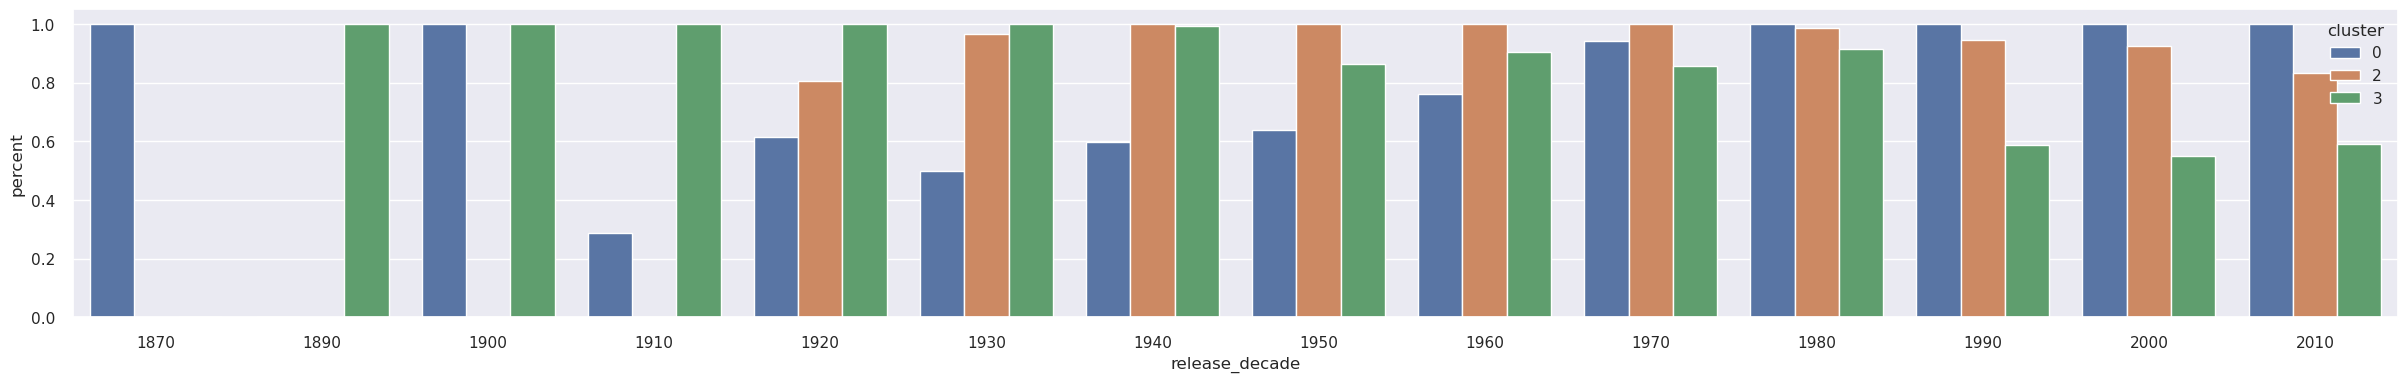

In [146]:
plot_cat_column_by_cluster(
    movies_clusters, 
    user_ratings_emb_df, 
    dataset, 
    dataset_column    = 'release_decade',
    target_column     = 'release_decade',
    figsize           = (30,4),
    excluded_clusters = [1]
)

### Observaciones

En algun sentido, el espacio latente esta representando perfiles de usuario generacionales. Es decir, cada cluster representa usuarios que tienden a votar con mayor rating peliculas que pertenecen a un segmento de decadas especifico. Tenemos 3 segmentos:

* Los que tiene a ver mas peliculas lanzadas a partir de los 80's (Cluster 0).
* Los que tiene a ver mas peliculas lanzadas entre los 70's y 50's (Cluster 2).
* Los que tiene a ver mas peliculas lanzadas hasta los 20's (Cluster 3).

Las peliculas para adultos tienden a decrecer casi linelamente entre clusters. Siendo las peliculas mas nuevas mas calificada para adultos, decreciendo para decada anteriores.

Por otro lado existe una relacion directa entre los generos y la marca para adultos en cada cluster. Se entiende que cada genero tiene mas o menos preponderancia a ser marcado como **para adultos**, pero tambien es comprensible que peliculas mas nuevas tenga mas componentes que las hace menos aptas para menores.  